# Sparse signal recovery with Huber objective

The objective is to solve the following optimization problem:

$
\min_x \; \phi(Ax - y) \quad \text{subject to} \quad \|x\|_1 \leq N
$

where $\phi$ is the Huber function, defined as:

$
\phi(y) = \sum_i h(y_i),
$

with

$
h(u) = 
\begin{cases} 
      u^2 & \text{if } |u| \leq 1, \\
      2|u| - 1 & \text{if } |u| \geq 1.
   \end{cases}
$

We start by randomly generating $A$ and $y$:

In [19]:
import numpy as np

# Generate random signal
np.random.seed(0)


# Generate random signal
n = 1000
n_nnz = 10
hat_x = np.zeros(n)
nnz_idx = np.random.randint(0,n,n_nnz)
hat_x[nnz_idx] = np.random.randn(n_nnz)

# Samples
n_samples = 100
A = np.random.randn(n_samples,n)
y = A@hat_x


The goal of this function is to project a vector $x$ onto the L1-norm constraint set $C$, defined as:

$
C = \{ x \in \mathbb{R}^n : \|x\|_1 \leq N \}
$

where $N$ is a positive scalar.
We now define projection onto the l1 norm ball in code:

In [20]:
# L1 norm constraint
N = 10  


# Projection onto L1 norm constraint set
def project_onto_l1_ball(x, N):
    if np.linalg.norm(x, 1) <= N:
        return x
    u = np.abs(x)
    if u.sum() <= N:
        return x
    # Sort u in descending order
    s = np.sort(u)[::-1]
    # Find the threshold
    cssv = np.cumsum(s) - N
    ind = np.arange(len(s)) + 1
    cond = s - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / rho
    # Soft-thresholding
    return np.sign(x) * np.maximum(u - theta, 0)

#### We can define the Huber gradient as:

$
h(u) = 
\begin{cases} 
      u^2 & \text{if } |u| \leq 1, \\
      2|u| - 1 & \text{if } |u| \geq 1.
   \end{cases}
$

In [21]:
def huber_gradient(A, x, y):
    Ax_minus_y = A @ x - y
    grad = np.where(np.abs(Ax_minus_y) <= 1, 2 * Ax_minus_y, 2 * np.sign(Ax_minus_y))
    return A.T @ grad

We can then perform gradient descent with a projection step to ensure conditions are satisfied.

In [22]:
def gradient_descent(A, x, y, step_size=1e-4, max_iters=1000, tolerance=1e-4):
    for k in range(max_iters):
        # Compute gradient
        grad = huber_gradient(A, x, y)

        # Gradient descent step
        x = x - step_size * grad

        # Projection step
        x = project_onto_l1_ball(x, N)

        # Check for convergence
        if np.linalg.norm(grad) < tolerance:
            print(f"Converged in {k} iterations")
            break
    return x

# Run projected gradient descent
x = np.zeros(n)
x = gradient_descent(A, x, y)


We can plot the True signal and the Recovered signal on the same plot to observe the results.

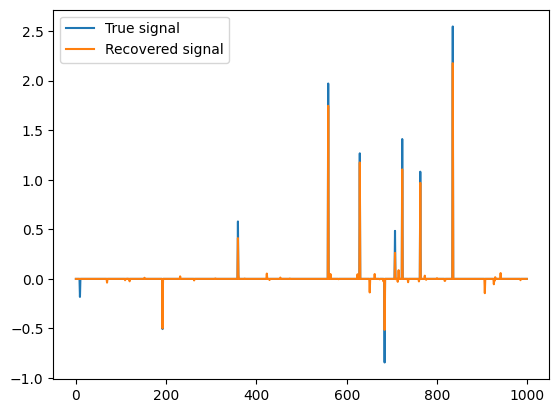

In [23]:

import matplotlib.pyplot as plt
plt.plot(hat_x, label="True signal")
plt.plot(x, label="Recovered signal")
plt.legend()
plt.show()
